In [ ]:
#Importing necessary libraries
import os
import torch
from torchvision import models, transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [5]:
# Define image preprocessing transformations
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],  
        std=[0.229, 0.224, 0.225]
    ),
])

In [ ]:
# Load pretrained ResNet50 model, remove classification head
model = models.resnet50(pretrained=True)
model = torch.nn.Sequential(*list(model.children())[:-1])  # Remove last fc layer
model.eval()

In [ ]:
# Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

In [8]:
# Path to your images folder
image_folder = "/home/slakkaraju/flowers/flowers"

In [9]:
# Store embeddings and image paths
embeddings = []
image_paths = []

with torch.no_grad():
    for img_file in os.listdir(image_folder):
        img_path = os.path.join(image_folder, img_file)
        try:
            image = Image.open(img_path).convert('RGB')
            input_tensor = preprocess(image).unsqueeze(0).to(device)  # Add batch dim
            embedding = model(input_tensor)
            embedding = embedding.squeeze().cpu().numpy()  # Flatten to 1D vector
            embeddings.append(embedding)
            image_paths.append(img_path)
        except Exception as e:
            print(f"Error processing {img_path}: {e}")

embeddings = np.array(embeddings)

In [ ]:
#Verifying values from 1st index
embeddings[0]

array([0.10267993, 0.29097244, 0.5115832 , ..., 0.21209209, 0.07435831,
       0.03825712], shape=(2048,), dtype=float32)

In [11]:
# Save embeddings and paths for later use (e.g., numpy file or pickle)
np.save('flower_image_embeddings.npy', embeddings)
with open('image_paths.txt', 'w') as f:
    for path in image_paths:
        f.write(f"{path}\n")

print(f"Extracted embeddings for {len(embeddings)} images.")

Extracted embeddings for 13862 images.


In [12]:
# Load embeddings saved earlier
embeddings = np.load('flower_image_embeddings.npy')

# Define number of clusters (adjust based on your data)
num_clusters = 10

In [13]:
# Apply K-Means clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(embeddings)

In [14]:
# Save cluster labels for each image
np.save('cluster_labels.npy', cluster_labels)
print("Clustering completed.")

Clustering completed.


In [15]:
# Load embeddings and cluster labels
embeddings = np.load('flower_image_embeddings.npy')
cluster_labels = np.load('cluster_labels.npy')

In [16]:
#Use PCA to reduce dimensionality before t-SNE for faster processing
pca = PCA(n_components=50)
embeddings_pca = pca.fit_transform(embeddings)

In [17]:
# Apply t-SNE for 2D visualization
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
embeddings_2d = tsne.fit_transform(embeddings_pca)

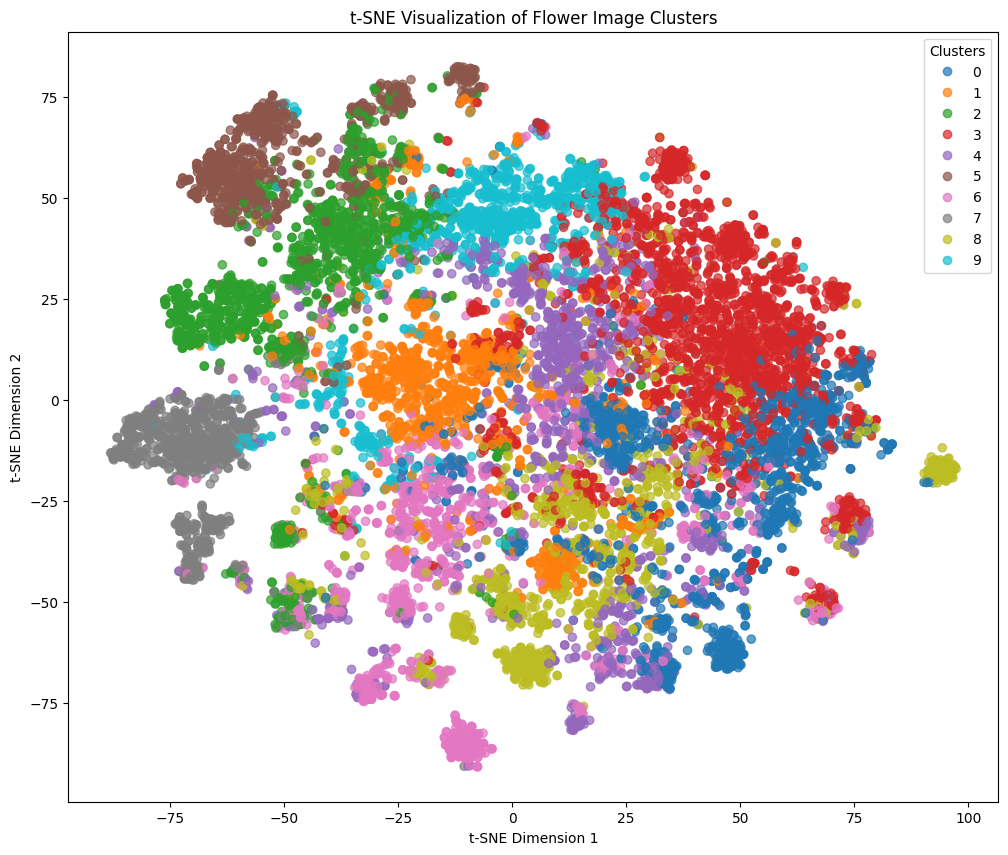

In [18]:
# Plot with clusters using different colors
plt.figure(figsize=(12, 10))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=cluster_labels, cmap='tab10', alpha=0.7)
plt.legend(*scatter.legend_elements(), title="Clusters")
plt.title("t-SNE Visualization of Flower Image Clusters")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.show()